In [27]:
import os
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt 
import pathlib
import numpy as np
from functools import partial
import pandas as pd
from tensorflow.keras import Sequential
from tensorflow.keras.applications.resnet50 import preprocess_input, ResNet50, decode_predictions 
import tensorflow_hub as hub
from keras.callbacks import ModelCheckpoint
import cv2

# Functions

In [55]:
batch_size = 16
AUTOTUNE = tf.data.AUTOTUNE
img_height, img_width =32,32



def get_class_names(data_dir):
    return np.array(sorted([item.name for item in data_dir.glob('*') ]))


def plot_comparison(original, filtered, title_0,title_1):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 8), sharex=True,
    sharey=True)
    ax1.imshow(original, cmap=plt.cm.gray)
    ax1.set_title(title_0)
    # ax1.axis('off')
    ax2.imshow(filtered, cmap=plt.cm.gray)
    ax2.set_title(title_1)

def decode_img(img):
  # Convert the compressed string to a 3D uint8 tensor
  img = tf.io.decode_jpeg(img, channels=3)
  # Resize the image to the desired size
  return tf.image.resize(img, [img_height, img_width])


def process_path(file_path):
    label = get_label(file_path)
  # Load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    # img = tf.image.rgb_to_grayscale(img)
    return img, label

def configure_for_performance(ds):
    ds = ds.cache()
    ds = ds.shuffle(buffer_size=1000)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

def display_im_grid(data_set, dim):
    image_batch, label_batch = next(iter(data_set))
    plt.figure(figsize=(10, 10))
    for i in range(dim**2):
        ax = plt.subplot(dim, dim, i + 1)
        plt.imshow(image_batch[i].numpy())
        label = label_batch[i]
        plt.title(class_names[label])
        plt.axis("off")
        
        
def get_class_names(data_dir):
    return np.array(sorted([item.name for item in data_dir.glob('*') ]))


def scale_img(img,label):
    return img/255.0, label


def get_label(file_path):
  # Convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  one_hot = parts[-2] == class_names
  # Integer encode the label
  return tf.argmax(one_hot)


def display_im_grid(data_set, dim):
    image_batch, label_batch = next(iter(data_set))
    plt.figure(figsize=(10, 10))
    for i in range(dim**2):
        ax = plt.subplot(dim, dim, i + 1)
        plt.imshow(image_batch[i].numpy(),cmap= 'gray')
        print(image_batch[i].numpy().mean())
        print(image_batch[i].numpy().shape)
        label = label_batch[i]
        plt.title(class_names[label])
        plt.axis("off")
        

def create_pred_test_series_data(data_set, model, normalizer =tf.keras.layers.BatchNormalization()):
    predict_list = []
    label_list = []
    im_list = []
    norm_layer = normalizer
    for batch in data_set: 
        pred_matrix = model.predict(batch[0], verbose = 2)
        im_list += [np.array(im) for im in norm_layer(batch[0])]
        predict_list += [np.argmax(pred) for pred in pred_matrix]
        label_list += [label.numpy() for label in batch[1]]
    return pd.Series(label_list) , pd.Series(predict_list) , im_list


def convert_dir_ds_to_numpy(ds):
    x_list = []
    y_list = []
    for x,y in ds:
        x_list.append(x.numpy())
        y_list.append(y.numpy())
    x = np.concatenate(x_list)
    x = x.reshape(x.shape[0:3])
    
    y = np.concatenate(y_list).astype(np.uint8)
    return x,y


def add_border(img, border_size = 4 ,border_color = 1):
    img = img.copy()
    # make Left Column Black
    img[0:img.shape[0], 0:border_size] = border_color
    # make Right Column Black
    img[0:img.shape[0], (img.shape[1]-border_size):img.shape[1]] = border_color
    # make top rows Black
    img[0:border_size, 0:img.shape[1]] = border_color
    #make bottom rows black
    img[(img.shape[0]-border_size):img.shape[0],0:img.shape[1]] = border_color
    return img


# Create Data Directory

In [56]:
data_dir = pathlib.Path('.\\image_classification_training_data')
str(data_dir)

'image_classification_training_data'

In [57]:
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'), shuffle=False)
image_count = len(list_ds)
list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=False , seed = 448)

# Create Training and Validation Set

In [58]:
val_size = int(image_count * 0.25)
train_ds = list_ds.skip(val_size)
val_ds = list_ds.take(val_size)

In [59]:
print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())

443
147


In [60]:
class_names = get_class_names(data_dir)
print(class_names)

['0' '1' '2' '3' '4' '5' '6' '7' '8' '9']


In [61]:
train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE).map(scale_img)
val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE).map(scale_img)

In [62]:
train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)

0.7037082
(32, 32, 1)
0.6764488
(32, 32, 1)
0.8357009
(32, 32, 1)
0.70888346
(32, 32, 1)
0.7219839
(32, 32, 1)
0.6796415
(32, 32, 1)
0.71901596
(32, 32, 1)
0.7054086
(32, 32, 1)
0.66871977
(32, 32, 1)


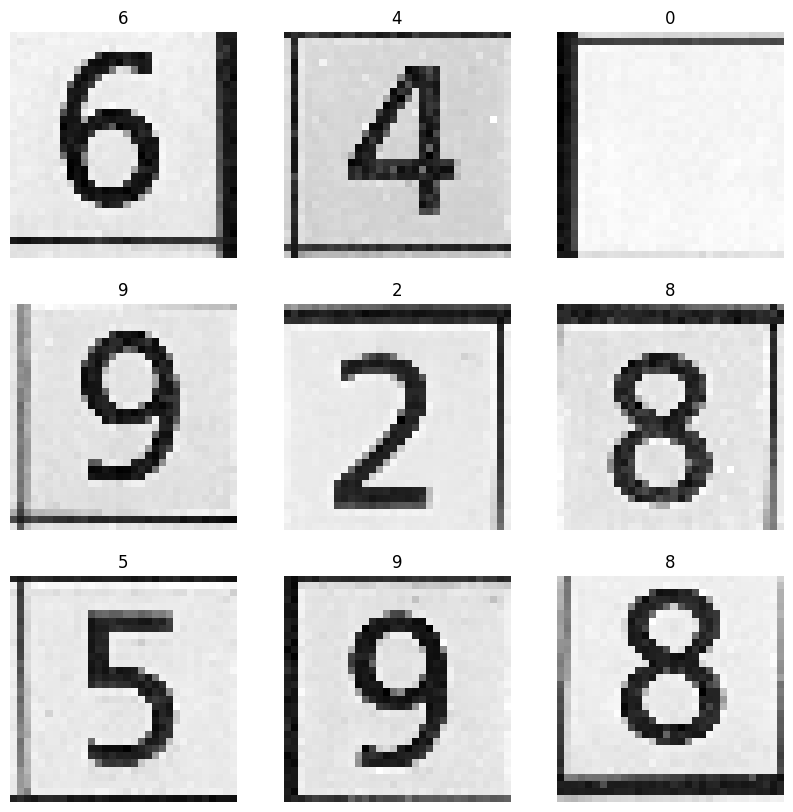

In [51]:
display_im_grid(train_ds,3)

In [37]:
# num_classes = 10
# model = tf.keras.Sequential([
#   tf.keras.layers.BatchNormalization(),
#   tf.keras.layers.Conv2D(64, 3, activation='relu'),
#   tf.keras.layers.MaxPooling2D(),
#   tf.keras.layers.Conv2D(32, 3, activation='relu'),
   
#   tf.keras.layers.MaxPooling2D(),
#   tf.keras.layers.Conv2D(16, 3, activation='relu'),

#   tf.keras.layers.MaxPooling2D(),
#   tf.keras.layers.Flatten(),
#   tf.keras.layers.Dense(32, activation='relu'),
#   tf.keras.layers.Dense(num_classes,activation = 'softmax')
# ])
# # tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
# model.compile(
#   optimizer='adam',
#   loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
#   metrics=['accuracy'])


In [39]:
class_weights = {0: 4.0, 1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0, 5: 1.0, 6: 1.0, 7: 1.0, 8: 1.0, 9: 1.0}
num_classes = 10
model = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.25),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(16, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])
# tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
  metrics=['accuracy'])


In [63]:
class_weights = {0: 4.0, 1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0, 5: 1.0, 6: 1.0, 7: 1.0, 8: 1.0, 9: 1.0}
# Load pre-trained VGG16 model
base_model = tf.keras.applications.VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(32, 32, 3)
)

# Freeze the base model layers
base_model.trainable = False

# Add classification layers on top
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [64]:
file_path = r"C:\Users\MA51801\Documents\Projects\Sudoku_Project\digit_classifier_model\digit_classifier_vgg16.hdf5"
checkpoint = ModelCheckpoint(file_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
with tf.device('/GPU:0'):
    training = model.fit(train_ds,epochs = 100 ,validation_data= val_ds, callbacks=[checkpoint],class_weight=class_weights)

Epoch 1/100
28/28 [==============================] - ETA: 0s - loss: 1.7729 - accuracy: 0.5147
Epoch 1: val_loss improved from inf to 0.92076, saving model to C:\Users\MA51801\Documents\Projects\Sudoku_Project\digit_classifier_model\digit_classifier_vgg16.hdf5
28/28 [==============================] - 3s 67ms/step - loss: 1.7729 - accuracy: 0.5147 - val_loss: 0.9208 - val_accuracy: 0.8503
Epoch 2/100
25/28 [=========================>....] - ETA: 0s - loss: 0.6780 - accuracy: 0.8875
Epoch 2: val_loss improved from 0.92076 to 0.45752, saving model to C:\Users\MA51801\Documents\Projects\Sudoku_Project\digit_classifier_model\digit_classifier_vgg16.hdf5
28/28 [==============================] - 1s 23ms/step - loss: 0.6471 - accuracy: 0.8984 - val_loss: 0.4575 - val_accuracy: 0.8912
Epoch 3/100
25/28 [=========================>....] - ETA: 0s - loss: 0.3493 - accuracy: 0.9425
Epoch 3: val_loss improved from 0.45752 to 0.28558, saving model to C:\Users\MA51801\Documents\Projects\Sudoku_Project\

In [55]:
labels, predictions, imgs = create_pred_test_series_data(val_ds,model)

pd.crosstab(labels, predictions , margins = True)

tf.Tensor(6, shape=(), dtype=int64)
1/1 - 0s - 119ms/epoch - 119ms/step
tf.Tensor(0, shape=(), dtype=int64)
1/1 - 0s - 21ms/epoch - 21ms/step
tf.Tensor(9, shape=(), dtype=int64)
1/1 - 0s - 20ms/epoch - 20ms/step
tf.Tensor(4, shape=(), dtype=int64)
1/1 - 0s - 20ms/epoch - 20ms/step
tf.Tensor(0, shape=(), dtype=int64)
1/1 - 0s - 19ms/epoch - 19ms/step
tf.Tensor(9, shape=(), dtype=int64)
1/1 - 0s - 22ms/epoch - 22ms/step
tf.Tensor(3, shape=(), dtype=int64)
1/1 - 0s - 21ms/epoch - 21ms/step
tf.Tensor(5, shape=(), dtype=int64)
1/1 - 0s - 23ms/epoch - 23ms/step


col_0,0,1,2,3,4,5,6,7,8,9,All
row_0,,,,,,,,,,,
0,16,0,0,0,0,0,0,0,0,0,16
1,0,8,0,0,0,0,0,1,0,0,9
2,0,0,15,0,0,0,0,0,0,0,15
3,0,0,0,15,0,0,0,0,0,0,15
4,0,0,0,0,11,0,0,0,0,0,11
5,0,0,0,0,0,7,0,0,0,0,7
6,0,0,0,0,0,0,12,0,0,0,12
7,0,0,0,0,0,0,0,8,0,0,8
8,0,0,0,0,0,0,0,0,13,0,13


In [225]:
np.where(labels != predictions)

(array([48], dtype=int64),)

1


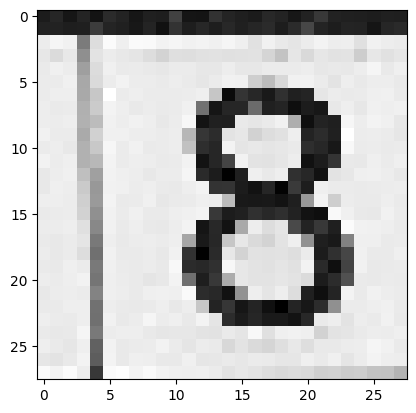

In [226]:
im_index = 48
plt.imshow(imgs[im_index],cmap='gray')
print(predictions[im_index])

In [227]:
print(predictions[im_index])

1


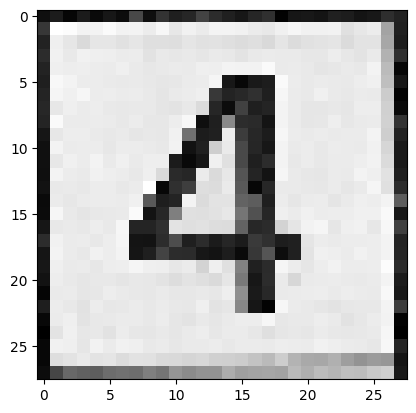

In [57]:
plt.imshow(imgs[4],cmap='gray')

In [45]:
# opt = keras.optimizers.SGD(learning_rate=0.01, momentum = 0.8)
# resnet_model = Sequential()
# # resnet_model.add(tf.keras.layers.BatchNormalization())
# pretrained_model = ResNet50(include_top = False, weights='imagenet', input_shape=(28,28,1),pooling='avg',classes=10)
# for layer in pretrained_model.layers:
#         layer.trainable=False
# resnet_model.add(pretrained_model)
# resnet_model.add(tf.keras.layers.Flatten())
# resnet_model.add(tf.keras.layers.Dense(32, activation = 'relu'))
# resnet_model.add( tf.keras.layers.Dense(10,activation = 'softmax'))
# resnet_model.compile(optimizer = 'adam', loss =tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False) , metrics = ['accuracy'])


In [44]:
# with tf.device('/GPU:0'):
#     training = resnet_model.fit(train_ds,epochs = 40 ,validation_data= val_ds)

In [1]:
# mnist_model = Sequential()
# pretrained_model=  Sequential([hub.KerasLayer("https://tfhub.dev/tensorflow/tfgan/eval/mnist/logits/1",  input_shape=(28 , 28,1))])
# for layer in pretrained_model.layers:
#     layer.trainable=False
# mnist_model.add(pretrained_model)
# mnist_model.add(tf.keras.layers.Flatten())
# # mobile_net.add(Dense(64, activation = 'relu'))
# mnist_model.add(tf.keras.layers.Dense(10, activation = 'softmax'))
# mnist_model.compile(optimizer = 'adam',loss =tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False) , metrics = ['accuracy'])
# mnist_model.summary()

In [2]:
# with tf.device('/GPU:0'):
#     training = mnist_model.fit(train_ds,epochs = 200 ,validation_data= val_ds)

# Train on MNIST data Validate on Blockbuster Sudoku Images

In [21]:
# Load MNIST dataset
(x_train, y_train), (x_test_mnist, y_test_mnist) = tf.keras.datasets.mnist.load_data()
# Normalize Mnist Images
x_train = x_train/255
# Invert Black and White In Order To align with Blockbuster Sudoku Dataset
x_train = 1 -x_train
x_train = np.array([add_border(img,2) for img in x_train])

### Need to turn Blockbuster Sudoku Image and Labels into MNIST For

In [32]:
x_test_1, y_test_1 = convert_dir_ds_to_numpy(train_ds)
x_test_2, y_test_2 = convert_dir_ds_to_numpy(val_ds)
x_test = np.concatenate([x_test_1, x_test_2], axis =0)
y_test = np.concatenate([y_test_1, y_test_2], axis =0)
x_test = np.array([add_border(img,3) for img in x_test])

### Example Test Image From Blockbuster Sudoku

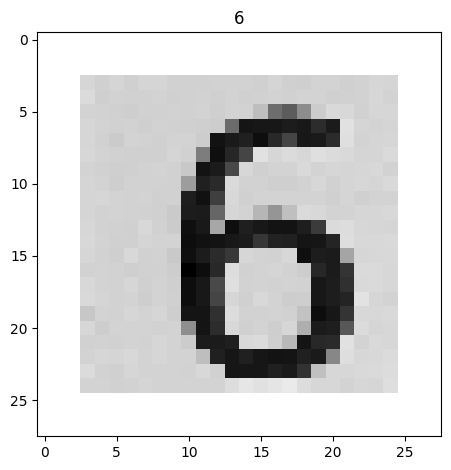

In [33]:
im_index = 7
plt.imshow(x_test[im_index],cmap='gray')
plt.title(y_test[im_index])
plt.tight_layout()

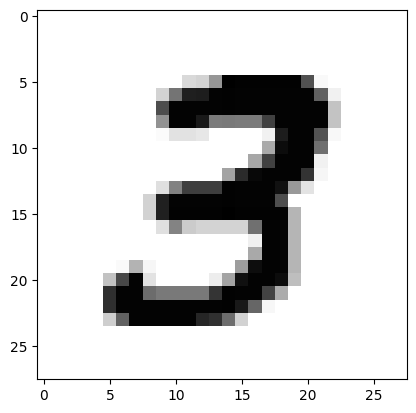

In [34]:
def add_border(img, border_size = 4 ,border_color = 1):
    img = img.copy()
    # make Left Column Black
    img[0:img.shape[0], 0:border_size] = border_color
    # make Right Column Black
    img[0:img.shape[0], (img.shape[1]-border_size):img.shape[1]] = border_color
    # make top rows Black
    img[0:border_size, 0:img.shape[1]] = border_color
    #make bottom rows black
    img[(img.shape[0]-border_size):img.shape[0],0:img.shape[1]] = border_color
    return img
test_img = add_border(x_train[im_index], border_size = 4)

plt.imshow(test_img,cmap='gray')

In [66]:
taco = None
if not taco:
    print('No Taco')

No Taco


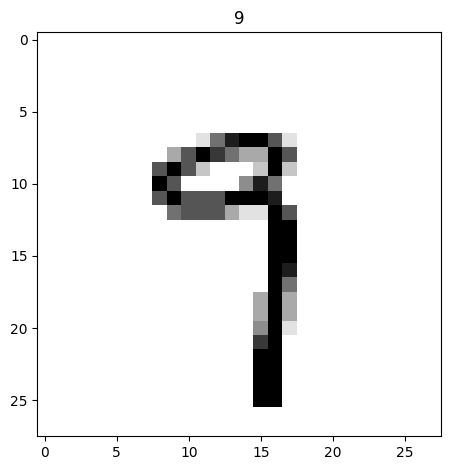

In [35]:
im_index = 304
plt.imshow(x_train[im_index],cmap = 'gray')
plt.title(y_train[im_index])
plt.tight_layout()

### Use Same Architecture as Before

In [36]:
num_classes = 10
model = tf.keras.Sequential([
  tf.keras.layers.Reshape((28, 28, 1), input_shape=(28, 28)),
  tf.keras.layers.Conv2D(32, 3, activation='relu', padding='same'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Conv2D(32, 3, activation='relu', padding='same'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
  tf.keras.layers.Dropout(0.25),
  tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
  tf.keras.layers.Dropout(0.25),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(512, activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(num_classes,activation = 'softmax')
])
# tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
  metrics=['accuracy'])

In [37]:
file_path = r"C:\Users\MA51801\Documents\Projects\Sudoku_Project\digit_classifier_model\digit_classifier_mnist_train.hdf5"
checkpoint = ModelCheckpoint(file_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
with tf.device('/GPU:0'):
    training = model.fit(x_train,y_train,epochs = 5 ,validation_data= (x_test,y_test), callbacks=[checkpoint])

Epoch 1/5
1875/1875 [==============================] - ETA: 0s - loss: 0.1458 - accuracy: 0.9552
Epoch 1: val_accuracy improved from -inf to 0.73086, saving model to C:\Users\MA51801\Documents\Projects\Sudoku_Project\digit_classifier_model\digit_classifier_mnist_train.hdf5
1875/1875 [==============================] - 170s 90ms/step - loss: 0.1458 - accuracy: 0.9552 - val_loss: 1.2484 - val_accuracy: 0.7309
Epoch 2/5
1875/1875 [==============================] - ETA: 0s - loss: 0.0692 - accuracy: 0.9795
Epoch 2: val_accuracy improved from 0.73086 to 0.76102, saving model to C:\Users\MA51801\Documents\Projects\Sudoku_Project\digit_classifier_model\digit_classifier_mnist_train.hdf5
1875/1875 [==============================] - 171s 91ms/step - loss: 0.0692 - accuracy: 0.9795 - val_loss: 0.9874 - val_accuracy: 0.7610
Epoch 3/5
1875/1875 [==============================] - ETA: 0s - loss: 0.0538 - accuracy: 0.9832
Epoch 3: val_accuracy improved from 0.76102 to 0.80278, saving model to C:\Users

KeyboardInterrupt: 

'[1, 2, 3]'

# Imports